# Space influenza  

A toy-model binary classification task taken from [Martin 2018](https://www.packtpub.com/product/bayesian-analysis-with-python-second-edition/9781789341652) and [Martin et al. 2021](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_bart as pmb

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation

In [3]:
sin = np.loadtxt("space_influenza.csv", skiprows=1, delimiter=",")

X = sin[:, 1][:, None]
Y = sin[:, 2]
Y_jittered = np.random.normal(Y, 0.02)

In [4]:
idatas = {}
ms = ["10", "20", "50", "100", "200"]

for m in ms:
    with pm.Model() as model:
        μ = pmb.BART("μ", X, Y, m=int(m))
        p = pm.Deterministic("p", pm.math.sigmoid(μ))
        y = pm.Bernoulli("y", p=p, observed=Y)
        idata = pm.sample(idata_kwargs={"log_likelihood": True})

    idatas[m] = idata

Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 80 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (3 chains in 3 jobs)
PGBART: [μ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 162 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [5]:
for idata in idatas.values():
    print(az.ess(idata, var_names="p")["p"].mean().values.item())

417.3215219411551
466.7933009490614
482.4120589052621
491.94786810285456
500.9768170674831


In [6]:
for idata in idatas.values():
    print(az.rhat(idata, var_names="p")["p"].mean().values.item())

1.0091632395120111
1.0070603428271485
1.0064935556521095
1.0090757753013782
1.0049071263249354


/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circula

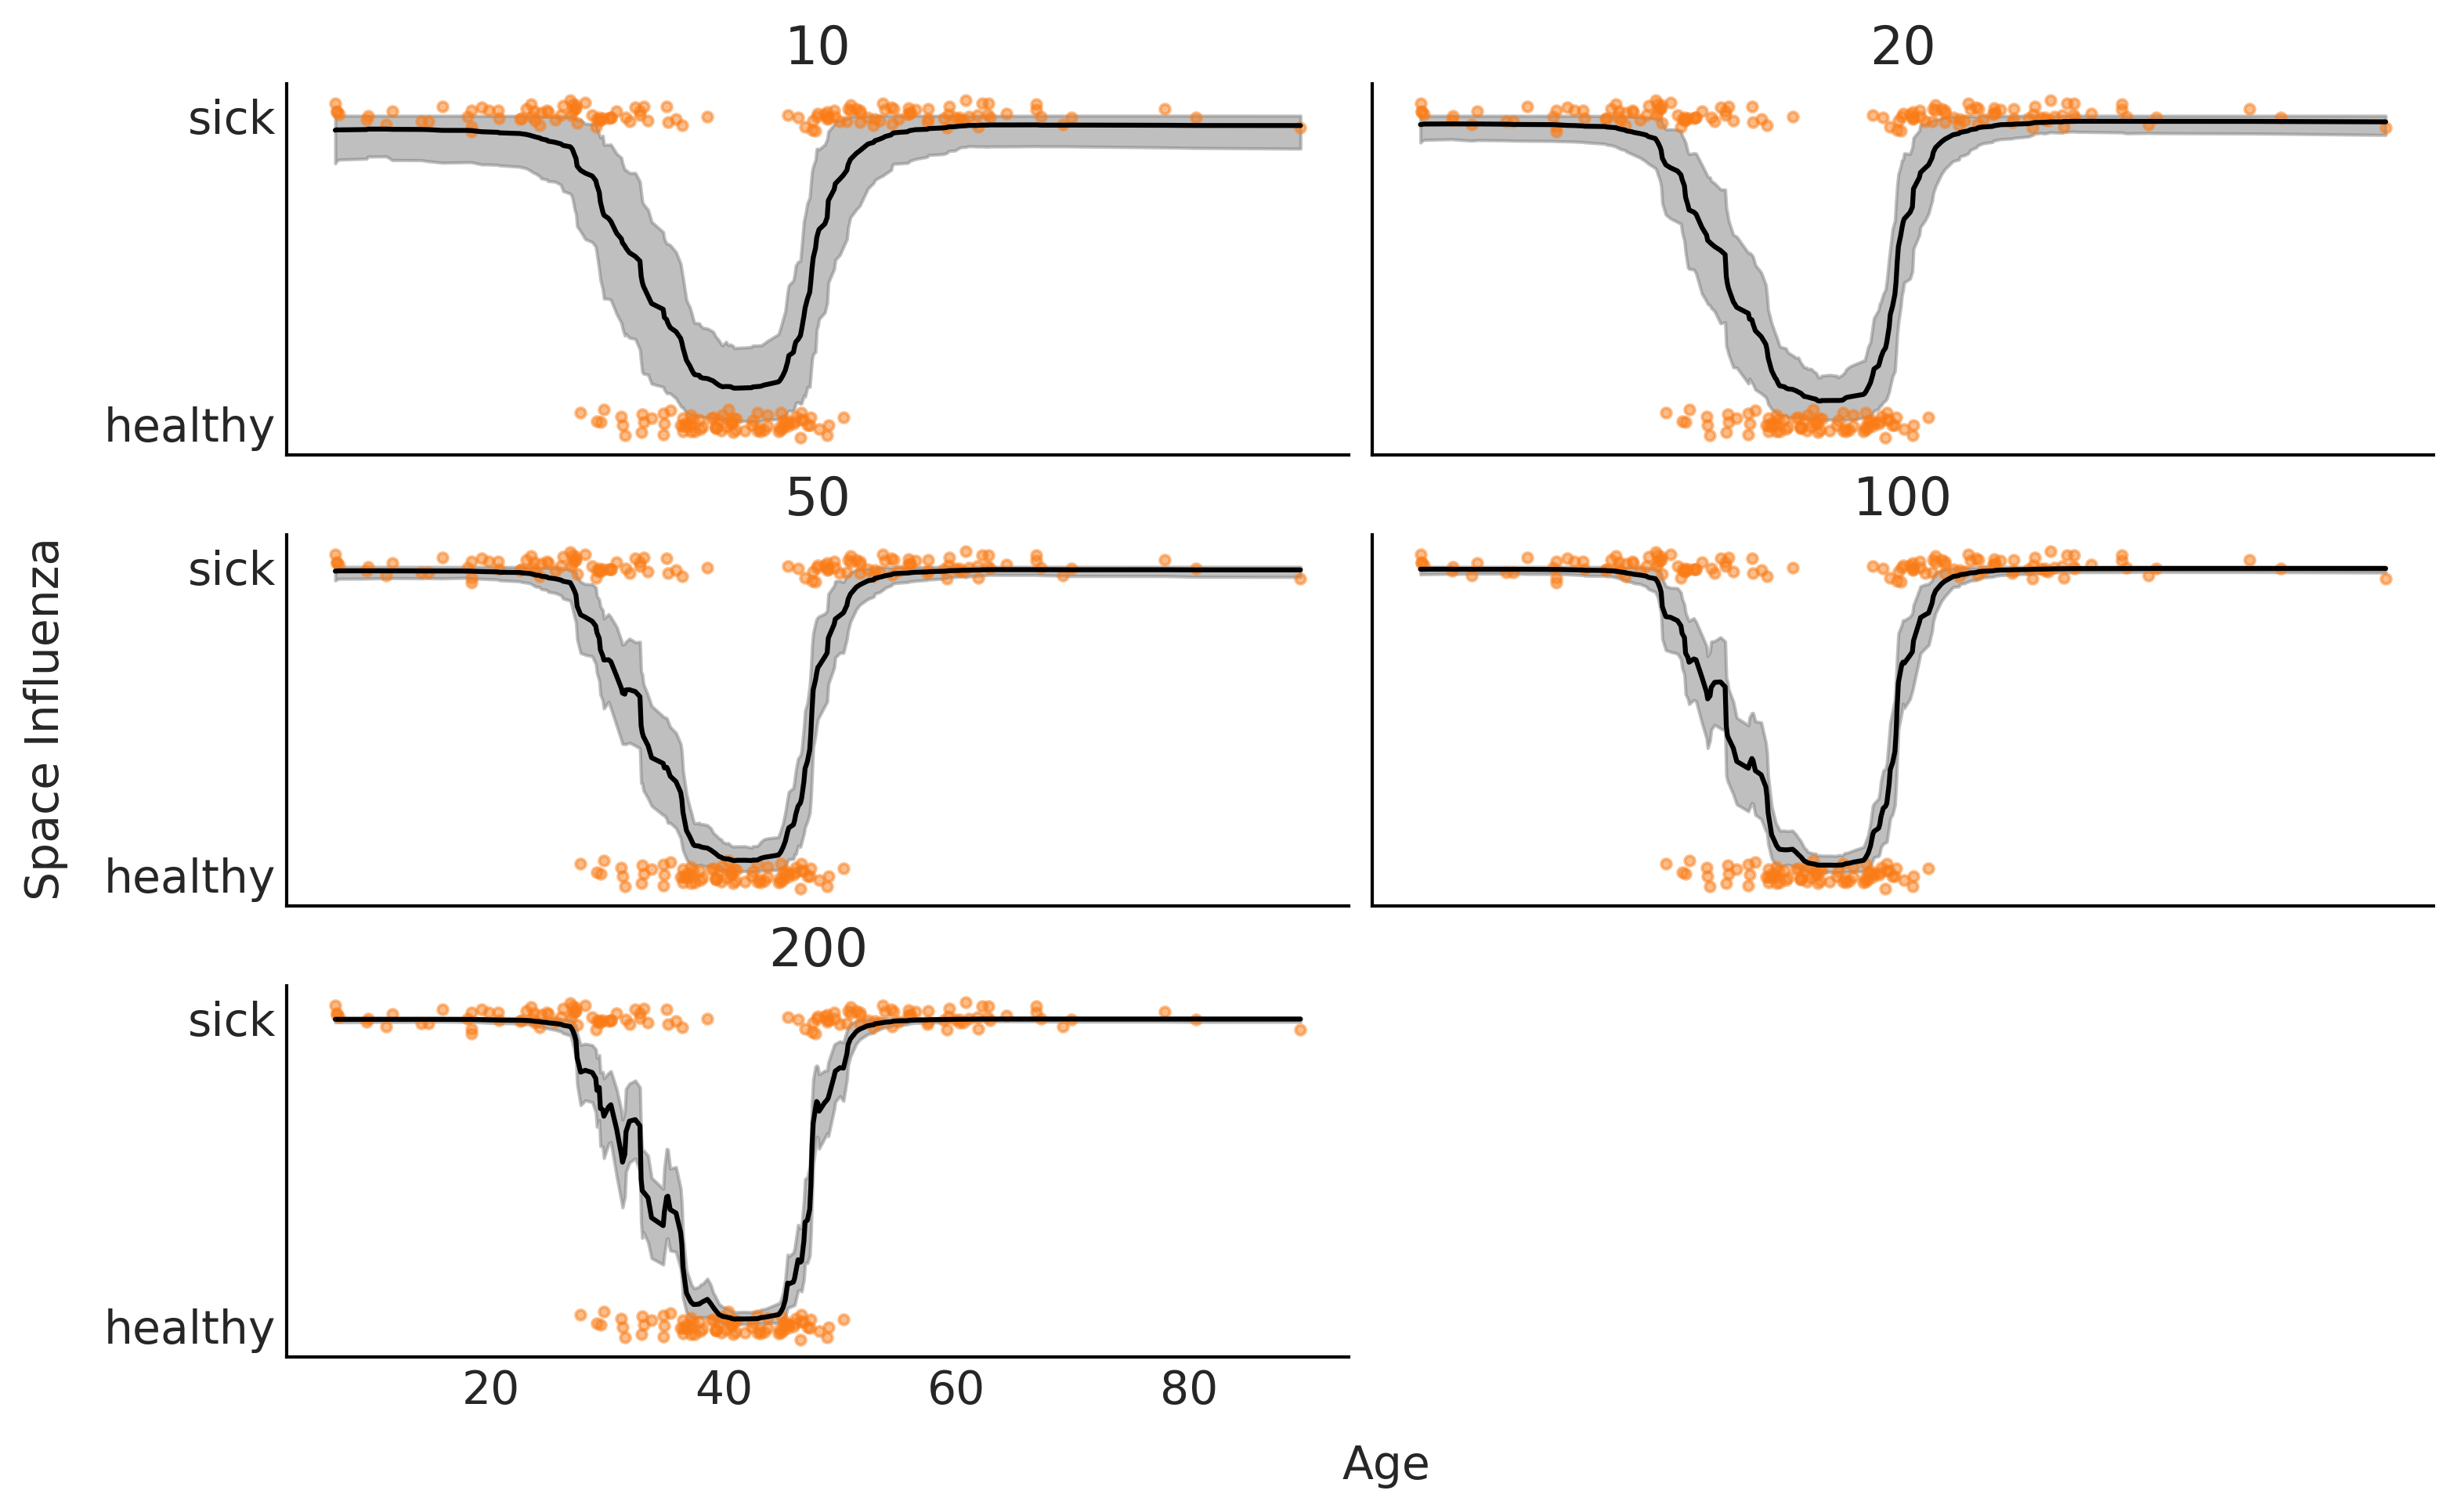

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=True, sharex=True)

for ax, (m, idata) in zip(np.ravel(axes), idatas.items()):
    ps = idata.posterior["p"].stack({"draws": ["chain", "draw"]})

    ax.plot(X, Y_jittered, "C1.", alpha=0.5)

    X_idx = np.argsort(X[:, 0])
    ax.plot(X[:, 0][X_idx], np.mean(ps, 1)[X_idx], "k-")

    az.plot_hdi(X[:, 0], ps.T, ax=ax, smooth=False, color="0.5", hdi_prob=0.95)
    ax.set_title(m)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["healthy", "sick"])
axes[2, 1].remove()
fig.text(0.55, -0.04, "Age", ha="center", size=14)
fig.text(-0.03, 0.5, "Space Influenza", va="center", size=14, rotation=90)
plt.savefig("space_influenza_03.png", dpi=300, bbox_inches="tight")

In [8]:
cmp = az.compare(idatas)
cmp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
200,0,-49.985339,1.699596,0.000000,1.000000e+00,6.066851,0.000000,False,log
100,1,-53.351980,2.182283,3.366641,0.000000e+00,6.310372,0.397895,False,log
50,2,-56.553649,3.053322,6.568310,0.000000e+00,6.427460,0.646348,False,log
20,3,-62.079331,5.294469,12.093992,0.000000e+00,6.491518,0.927709,False,log
10,4,-70.331764,9.378250,20.346425,7.687406e-12,6.373039,1.183810,False,log


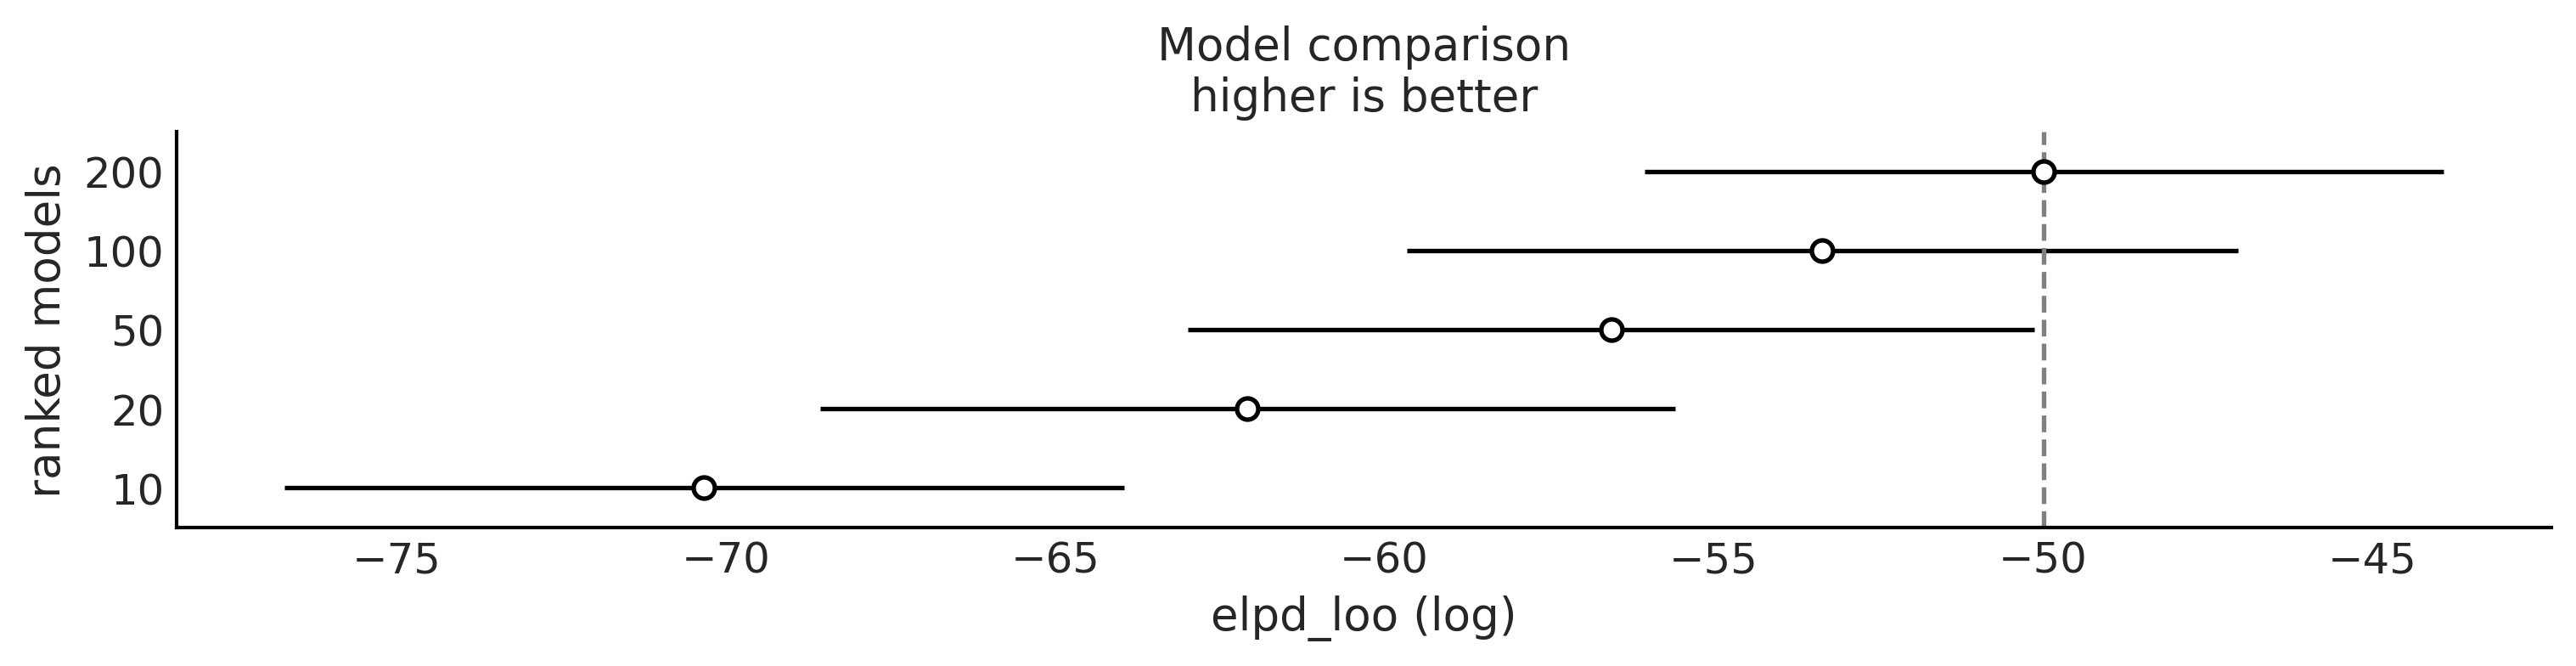

In [9]:
az.plot_compare(
    cmp, plot_ic_diff=False, insample_dev=False, figsize=(10, 2.5), legend=False
)
plt.savefig("space_influenza_loo.png");